In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

In [2]:
os.chdir("..")
print(os.getcwd())

C:\Work\ASTAR\autoBearing


In [3]:
from data_scripts.FEMTO import FEMTO

In [4]:
# Download the raw FEMTO files if it is not found
class arguments():
    def __init__(self):
        self.raw_dir = 'raw_data'
        self.processed_dir = 'processed_data'
        self.window_size = 1024
        self.stride = 0.2
        self.few_shots = [0.01, 0.05]

        self.fttp = True
        self.normalise = False
        
args = arguments()
FEMTO_class = FEMTO(args)
FEMTO_class.process_data()

In [6]:
unnorm = torch.load('processed_data/FEMTO/train.pt')
unnorm = unnorm['samples']
unnorm

tensor([[[ 0.0120,  0.6290, -0.2660,  ...,  0.1830,  0.3400,  0.3720],
         [-0.7280, -0.2400, -0.5980,  ..., -0.1350,  0.7220,  0.2170]],

        [[ 0.1450, -0.1230, -0.0030,  ..., -0.4970, -0.6750, -0.0750],
         [ 0.0370, -0.0540, -0.4930,  ...,  0.0560, -0.0090, -0.0700]],

        [[ 0.4450, -0.1080,  0.2840,  ..., -0.6960, -0.3670, -0.2390],
         [ 0.3250,  0.1830,  0.3400,  ...,  0.0820,  0.2590,  0.7400]],

        ...,

        [[-0.7480,  1.3260, -1.4660,  ...,  1.8820,  1.7910,  1.2390],
         [-0.8130, -1.4990,  1.8920,  ...,  0.0550, -1.0680,  0.4890]],

        [[-0.0430,  1.9300,  0.8060,  ...,  1.5850, -1.9660, -0.2230],
         [-1.0520,  0.1370, -1.7230,  ..., -0.5600,  0.3570,  1.6150]],

        [[ 1.5270, -0.1310, -1.6350,  ..., -1.2070,  0.0210, -1.9000],
         [ 1.5630,  1.8820,  1.7910,  ...,  2.4930, -0.5020, -1.9440]]],
       dtype=torch.float64)

In [7]:
from utils import normalise_tensor
norm = normalise_tensor(unnorm)
norm

tensor([[[-0.0157,  1.7496, -0.8111,  ...,  0.4735,  0.9227,  1.0143],
         [-2.2212, -0.7389, -1.8263,  ..., -0.4199,  2.1832,  0.6493]],

        [[ 0.3747, -0.4062, -0.0566,  ..., -1.4960, -2.0146, -0.2664],
         [ 0.0898, -0.1749, -1.4515,  ...,  0.1450, -0.0440, -0.2214]],

        [[ 1.2448, -0.3656,  0.7759,  ..., -2.0780, -1.1199, -0.7471],
         [ 0.9192,  0.5099,  0.9625,  ...,  0.2187,  0.7290,  2.1156]],

        ...,

        [[-0.4857,  0.9225, -0.9732,  ...,  1.3000,  1.2382,  0.8634],
         [-0.5295, -0.9967,  1.3127,  ...,  0.0617, -0.7031,  0.3572]],

        [[-0.0115,  1.3689,  0.5825,  ...,  1.1275, -1.3569, -0.1374],
         [-0.7162,  0.1124, -1.1839,  ..., -0.3734,  0.2657,  1.1424]],

        [[ 1.0908, -0.0754, -1.1332,  ..., -0.8322,  0.0315, -1.3196],
         [ 1.0893,  1.3095,  1.2467,  ...,  1.7311, -0.3358, -1.3309]]],
       dtype=torch.float64)

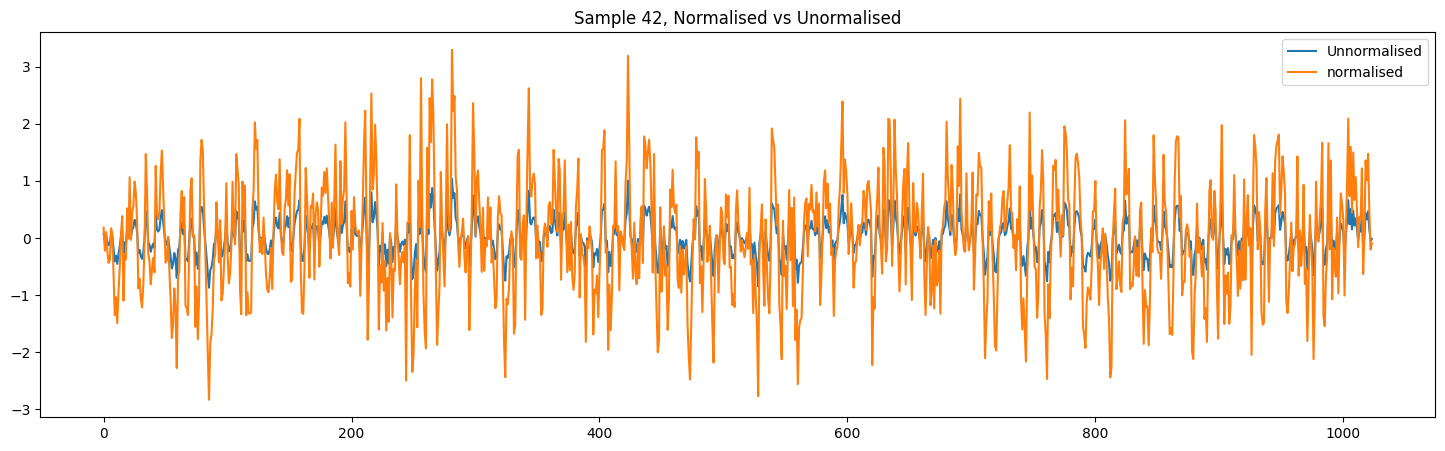

In [11]:
# Plotting random sample
plt.figure(figsize=(18,5))
plt.title(f'Sample 42, Normalised vs Unnormalised')
plt.plot(unnorm[42, 0], label='Unnormalised')
plt.plot(norm[42, 0], label='normalised')

plt.legend() 
plt.show()